In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

os.makedirs('../out/', exist_ok=True)

STATS_FILES = {
    'HSC_Lecco_2023': '../data/HSC_Lecco_2023-Players_Daily_Mobility_Stats.parquet',
}

SCORES_FILES = {
    'HSC_Lecco_2023': '../data/HSC_Lecco_2023-Players_Daily_Mobility_Scores.parquet',
}

In [2]:
import pandas as pd
import numpy as np

def load_stats(path: str, c: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df['distance'] = df['distance'] / 1000 # convert to km
    df['campaign'] = c
    df.rename(columns={'modeType': 'counter', 'distance': 'score', 'stat_date': 'ts'}, inplace=True)
    return df[['playerId', 'campaign', 'ts', 'counter', 'score']]

def load_scores(path: str, c: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df.rename(columns={'player_id': 'playerId', 'mobilityScore': 'score', 'day': 'ts'}, inplace=True)
    df['counter'] = 'score'
    df['campaign'] = c
    return df[['playerId', 'campaign', 'ts', 'counter', 'score']]

df_stats = pd.concat([load_stats(f, k) for k, f in STATS_FILES.items()])
df_scores = pd.concat([load_scores(f, k) for k, f in SCORES_FILES.items()])

df = pd.concat([df_stats, df_scores])
df['ts'] = pd.to_datetime(df['ts'])
df = df.groupby(['playerId', 'campaign', 'counter']).resample('W', on='ts').sum(numeric_only=True).reset_index()
df.sort_values('ts', ascending=True, inplace=True)
df['score'] = df['score'].round(2)
df

,playerId,campaign,counter,ts,score
903,u_16d0ed2ff1554b04b2297c913cdf874f,HSC_Lecco_2023,score,2023-02-26,0.00
132,u_038630b46b5d420796318493a484ce8c,HSC_Lecco_2023,score,2023-02-26,0.00
2125,u_3a209c2a3fff4c5f8a5553fd212760e7,HSC_Lecco_2023,score,2023-02-26,0.00
1062,u_1a125c7cf4cb4abdaa9d5b8f1d866fdf,HSC_Lecco_2023,score,2023-02-26,0.00
2960,u_4e195140e9e443fa8e52d36d6e226c25,HSC_Lecco_2023,score,2023-02-26,0.00
...,...,...,...,...,...
5734,u_8f20f2024b9e491cb01509df6147dd5f,HSC_Lecco_2023,bike,2023-05-28,33.63
10307,u_f57721f3785545aca0e23b1fbebf2f34,HSC_Lecco_2023,walk,2023-05-28,6.60
5750,u_8f20f2024b9e491cb01509df6147dd5f,HSC_Lecco_2023,score,2023-05-28,287.00
4962,u_782118d2b7e64e2ea824dd5ce926d3de,HSC_Lecco_2023,train,2023-05-28,19.92


In [3]:
def flatten(df: pd.DataFrame):
    return pd.Series({
        'start': df['ts'].min(),
        'scores': df[['walk', 'bike', 'train', 'bus', 'car', 'score']].values
    })

flattened_df = df.pivot(index=['playerId', 'campaign', 'ts'], columns='counter', values='score').fillna(0).reset_index()
flattened_df = flattened_df.groupby(['playerId', 'campaign']).apply(flatten, include_groups=False).reset_index()
flattened_df = flattened_df[flattened_df['scores'].apply(lambda x: np.sum(x) > 0 and len(x) > 2)]
flattened_df.sort_values('start', inplace=True)
flattened_df

,playerId,campaign,start,scores
188,u_540976ab95074dd797b0ff45a7e7cd28,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.83, 3.45, ..."
119,u_3a209c2a3fff4c5f8a5553fd212760e7,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [14.59, 0.0, ..."
293,u_80f670db5858452ea13da68b1fa207c9,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [4.97, 0.0, 0..."
54,u_16d0ed2ff1554b04b2297c913cdf874f,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [5.35, 0.0, 0..."
236,u_68a8eb940a5b4a98b7421090a8d77c42,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.17, 5.01, ..."
...,...,...,...,...
73,u_21b7d63bf4c84ad3a54ad5661bd256df,HSC_Lecco_2023,2023-04-02,"[[10.5, 0.0, 0.0, 146.72, 0.0, 510.0], [9.94, ..."
142,u_444d5c62cabe4384abace7fc620a3406,HSC_Lecco_2023,2023-04-02,"[[2.68, 1.98, 38.73, 0.0, 0.0, 141.0], [3.54, ..."
141,u_4422392da0284bd392c0ebf503b0bb68,HSC_Lecco_2023,2023-04-02,"[[20.35, 0.0, 0.0, 0.0, 0.0, 177.0], [9.77, 0...."
322,u_9075dccc48604c57b3459748241b6173,HSC_Lecco_2023,2023-04-02,"[[0.0, 0.0, 23.22, 0.0, 0.0, 38.0], [7.17, 0.0..."


<Axes: >

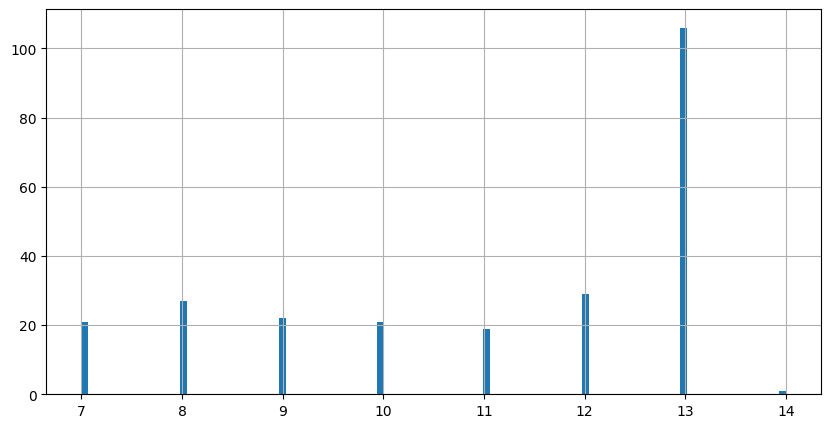

In [4]:
flattened_df['n'] = flattened_df['scores'].apply(lambda x: x.shape[0])
flattened_df = flattened_df[flattened_df['n'] > 6]

flattened_df['n'].hist(bins=100, figsize=(10, 5))

## Time-series analysis

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


class PerformancePredictorRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, layers: int = 1, dropout: float = 0.0):
        super(PerformancePredictorRNN, self).__init__()
        self.hidden_size = hidden_size
        dropout = 0.0 if layers == 1 else dropout

        assert layers >= 1
        self.rnn = nn.GRU(input_size, hidden_size, layers, bidirectional=False, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        assert len(x.shape) == 2
        out, _ = self.rnn(x)
        out = out[-1, :]
        out = self.fc(out)
        return out

    def _prepare_data(self, data):
        if self.scaler_ is not None:
            X = self.scaler_.fit_transform(data)
        X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
        return X[:-1], X[-1]

    def _train_loop(self, X, y, epochs, lr):
        self.to(DEVICE)
        self.train()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for _ in range(epochs):
            optimizer.zero_grad()
            output = self(X)
            loss: torch.Tensor = criterion(output, y)
            loss.backward()
            optimizer.step()

    # Fit the model
    def fit(self, performance_matrix, epochs=100, lr=0.01, scaler=None):
        self.scaler_ = scaler
        self.X_, self.y_ = self._prepare_data(performance_matrix)
        self._train_loop(self.X_, self.y_, epochs, lr)
        return self

    # Predict next week performance array
    def predict(self):
        self.to(DEVICE)
        self.eval()

        X = torch.cat([
            self.X_[1:],
            self.y_.reshape(1, -1)
        ], dim=0)

        y = self(X).cpu().detach().numpy()
        if self.scaler_ is not None:
            y = self.scaler_.inverse_transform(y.reshape(1, -1)).reshape(-1)
        y = np.maximum(y, 0) # ensure non-negative values

        return y

cuda


In [6]:
from sklearn.model_selection import TimeSeriesSplit

def mean_absolute_error(y_true, y_pred, ignore_zeros=False):
    if ignore_zeros:
        y_true = np.where(y_true == 0, np.nan, y_true)
    errors = np.abs(y_true - y_pred)
    return np.nanmean(errors, axis=0)

def root_mean_squared_error(y_true, y_pred, ignore_zeros=False):
    if ignore_zeros:
        y_true = np.where(y_true == 0, np.nan, y_true)
    errors = np.square(y_true - y_pred)
    return np.sqrt(np.nanmean(errors, axis=0))

def mean_absolute_percentage_error(y_true, y_pred, ignore_zeros=False):
    if ignore_zeros:
        y_true = np.where(y_true == 0, np.nan, y_true)
    errors = np.abs(y_true - y_pred) / y_true
    return np.nanmean(errors, axis=0)

def cross_validate(x: pd.Series, predict):
    dataframe = x['scores']
    tscv = TimeSeriesSplit(n_splits=5, test_size=1)

    preds = []
    ground_truths = []
    for train_index, test_index in tscv.split(dataframe):
        assert len(test_index) == 1

        y_true = dataframe[test_index].reshape(-1)
        y_hat = predict(dataframe[train_index])

        preds.append(y_hat)
        ground_truths.append(y_true)
    
    preds = np.array(preds)
    ground_truths = np.array(ground_truths)
    return pd.Series({
        'rmse': root_mean_squared_error(ground_truths, preds, ignore_zeros=False),
        'mae': mean_absolute_error(ground_truths, preds, ignore_zeros=False),
        #'mape': mean_absolute_percentage_error(ground_truths, preds, ignore_zeros=False)
    })

def global_mean(x: pd.Series):
    x = np.array(x.values.tolist())
    return np.nanmean(x, axis=0)

In [7]:
# Current predictor: moving average of the last 4 weeks

from tqdm import tqdm
tqdm.pandas()

def predict(X):
    return X[-4:].mean(axis=0) # moving average of the last 4 weeks
        
Y_hat: pd.DataFrame = flattened_df.progress_apply(cross_validate, axis=1, predict=predict).apply(global_mean).map('{:.2f}'.format)
Y_hat.index = ['walk', 'bike', 'train', 'bus', 'car', 'score']
Y_hat

100%|██████████| 246/246 [00:00<00:00, 1810.63it/s]


,rmse,mae
walk,4.58,3.92
bike,2.90,2.41
train,22.61,19.00
bus,8.75,7.43
car,5.28,4.44
score,90.40,75.41


In [8]:
from sklearn.preprocessing import StandardScaler as scaler

from tqdm import tqdm
tqdm.pandas()

def predict(X):
    model = PerformancePredictorRNN(
        input_size=6,
        hidden_size=64, 
        output_size=6,
        layers=1,
    )
    model = model.fit(X, epochs=200, lr=1e-4, scaler=scaler())
    return model.predict()

Y_hat: pd.DataFrame = flattened_df.progress_apply(cross_validate, axis=1, predict=predict).apply(global_mean).map('{:.2f}'.format)
Y_hat.index = ['walk', 'bike', 'train', 'bus', 'car', 'score']
Y_hat

100%|██████████| 246/246 [04:05<00:00,  1.00it/s]


,rmse,mae
walk,4.56,3.83
bike,2.65,2.11
train,22.88,18.97
bus,8.45,7.04
car,5.05,3.48
score,90.82,75.57


In [9]:
# POP predictor: take the last week score

from tqdm import tqdm
tqdm.pandas()


def predict(X):
    return X[-1] # take the last week score

Y_hat: pd.DataFrame = flattened_df.progress_apply(cross_validate, axis=1, predict=predict).apply(global_mean).map('{:.2f}'.format)
Y_hat.index = ['walk', 'bike', 'train', 'bus', 'car', 'score']
Y_hat

100%|██████████| 246/246 [00:00<00:00, 5008.71it/s]


,rmse,mae
walk,5.06,4.09
bike,2.91,2.22
train,25.18,20.07
bus,8.70,7.09
car,7.36,3.97
score,94.69,77.57
